In [1]:
# notebooky stuff
%load_ext autoreload
%autoreload 2
from IPython.display import display

import sys 
sys.path.append('../../modules')

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import eumf_data, eumf_eval, eumf_pipeline, eumf_custom_models
from sklearn import dummy, preprocessing, linear_model, model_selection, ensemble, pipeline
import seaborn as sns
from tqdm.notebook import tqdm
import statsmodels.api as sm
import json
import warnings


# pandas pretty output
pd.set_option('display.min_rows', 20)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load all data

In [2]:
# list of countries
countries = eumf_data.get_countries()
countries.remove("CY")

# migration rates
df_values = eumf_data.load_registrations_from_csv(impute_missing=True, countries=countries)

# google trends
df_trends = eumf_data.load_trends_from_csv(countries=countries)
keyword_ids = df_trends.columns.levels[0].tolist()

# macroeconomic data
df_gdp = eumf_data.read_gdp(countries=countries)
df_unempl = eumf_data.read_unempl(countries=countries)

country_combinations = [
    # ["GR", "CY"],
    ["LV", "LT", "EE"],
    ["BE", "NL", "LU"],
    ["CZ", "SK"],
    ["SE", "FI", "DK"],
    ["AT", "CH"]
]

panel = df_values.join(df_trends, how="outer")
panel_3m = panel.resample("3M", closed="left").mean()

panel_comb = eumf_data.combine_countries(panel, combinations=country_combinations)
panel_comb_3m = eumf_data.combine_countries(panel_3m, combinations=country_combinations)
df_gdp_comb = eumf_data.combine_countries(df_gdp, combinations=country_combinations)
df_unempl_comb = eumf_data.combine_countries(
    df_unempl, combinations=country_combinations, average=True
)
# note: strictly, unweighted average is wrong for unemployment, but should work in most cases

panel_comb_3m_macro = panel_comb_3m.join(df_gdp_comb).join(df_unempl_comb)

panel_comb_3m_macro["2017":"2018"]


/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:238: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)
/home/stei509/eu_migration_forecast/notebooks/final_paper/../../modules/eumf_data.py:279: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


10                                                                                                                       11                                                                                                                                            112                                                                                                               ...   value                                                                                                                                     gdp                                                                                                                                                unempl                                                                                                      
            AT+CH  BE+NL+LU  BG  CZ+SK    ES      FR      GB    GR   HR   HU   IE     IT   LV+LT+EE    PL    PT   RO  SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR     HR      HU      IE      IT   LV+LT+EE    PL      PT      RO   SE+FI+DK  SI   AT+CH  BE+NL+LU    BG    CZ+SK      ES      FR      GB      GR      HR      HU      IE      IT   LV+LT+EE    PL    ...     ES        FR        GB        GR        HR        HU       IE        IT     LV+LT+EE     PL        PT        RO     SE+FI+DK    SI     AT+CH   BE+NL+LU    BG    CZ+SK     ES      FR      GB      GR      HR      HU      IE       IT   LV+LT+EE    PL      PT      RO   SE+FI+DK    SI   AT+CH  BE+NL+LU  BG  CZ+SK   ES   FR   GB    GR    HR   HU   IE    IT  LV+LT+EE  PL   PT   RO  SE+FI+DK  SI 
date                                                                                                                                                                                                                                                                                                                                                                                                   ...                                                                                                                                                                                                                                                                                                                                                                                                            
2017-03-31  10.524  16.048   0.0   0.0  26.667  21.857  21.381  0.0  0.0  0.0  0.0  14.095    0.0     6.095  0.0  0.0  21.286   0.0  34.714  60.190    2.190  10.857  38.714  29.810  53.381  10.000  0.000   0.619  11.095  22.048    0.0    11.952  12.714  11.571  26.524   0.0  97.190  178.952  42.238  127.048  33.143  63.333  47.286   9.000  63.095  62.810  59.333  14.905  179.429  39.524  ...  1689.000  1268.333  1080.333  2327.333  4459.000  3747.667  156.000  5255.333  1396.333  12264.667  866.333  18186.333  654.333  420.333  28780.0  42970.0  1510.0  7620.0  5950.0  8450.0  9080.0  3760.0  2590.0  2820.0  14640.0  6800.0  10490.0  2760.0  4520.0  1850.0  33780.0  4790.0  2.85    6.433   6.6  6.00  18.2  9.6  4.6  22.4  12.7  4.3  7.4  11.6   7.333   5.3  9.8  5.3   7.167   7.4
2017-06-30   4.952  14.810   0.0   0.0  21.048  13.952  18.857  0.0  0.0  0.0  0.0  15.286    0.0     6.524  0.0  0.0  27.714   0.0  39.286  61.619   10.619   7.714  24.381  27.952  55.714   4.714  2.333   7.095  20.619  17.286    0.0    13.810  23.143  11.143  32.857   0.0  85.619  168.905  35.190   83.429  23.810  57.857  48.000  11.905  33.048  27.905  62.810  14.286  126.667  21.476  ...  1427.667  1023.333  1049.000  2113.333  4121.333  3637.667  164.667  4699.000  1407.000  12940.000  609.667  19264.000  520.333  365.000  29250.0  44540.0  1800.0  8470.0  6330.0  8560.0  8980.0  4120.0  2990.0  3200.0  14700.0  7140.0  11780.0  2960.0  4790.0  2200.0  35590.0  5260.0  2.70    5.867   6.2  5.75  17.3  9.6  4.4  21.8  11.5  4.3  6.7  11.3   7.667   5.1  9.2  4.9   7.133   6.6
2017-09-30   4.905  16.095   0.0   0.0  12.429  21.048  16.

## Global definitions

In [3]:
T_MIN = "2010"
T_MAX = "2019"

T_TEST_MIN = "2019"
T_TEST_MAX = "2019"

cv_default = eumf_eval.BlockKFold(n_splits=8, margin=1.0)
cv_random = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
# n_countries = len(panel_comb_3m_macro["value"].columns)
# cv_time = model_selection.TimeSeriesSplit(test_size=4 * n_countries, n_splits=6)

cv_scores_global, test_scores_global = [], []

with open("best_feature_combinations.json") as f:
    best_feature_combinations = json.load(f)

selected_keyword_ids = [
    "19",
    "118",
    "28",
    "24",
    "123",
    "119",
    "39",
    "115",
    "124",
    "117",
]

lags_default = [1, 2, 3, 4, 5, 6, 7, 8]
alternate_lags_default = {
    "value": [2, 3, 4, 5, 6, 7, 8],
    "gdp": [2, 3, 4, 5, 6, 7, 8],
    "unempl": [2, 3, 4, 5, 6, 7, 8],
}

variables_default = ["value", "gdp", "unempl"] + selected_keyword_ids


## Create comparison models

In [4]:
### TRAINING


model_names = [
    "bench_const_0",
    "bench_previous_2",
    "linear_without_ar",
    "linear_all",
    "linear_without_google",
    "ensemble_without_ar",
    "ensemble_all",
    "ensemble_without_google",
]

features = [
    ["value_2"],
    ["value_2"],
    best_feature_combinations["linear"]["without_ar"],
    best_feature_combinations["linear"]["all"],
    best_feature_combinations["linear"]["without_google"],
    best_feature_combinations["ensemble"]["without_ar"],
    best_feature_combinations["ensemble"]["all"],
    best_feature_combinations["ensemble"]["without_google"],
]

estimators = [
    dummy.DummyRegressor(strategy="constant", constant=0),
    eumf_custom_models.LinearDummyModel(coef=[1.0]),
    linear_model.HuberRegressor(epsilon=1.1, alpha=0.08),
    linear_model.HuberRegressor(epsilon=1.7, alpha=0.00008),
    linear_model.HuberRegressor(epsilon=1.0, alpha=0.002),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=9),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=11),
    ensemble.RandomForestRegressor(random_state=42, min_samples_leaf=12),
]

tuners = []
cv_scores, test_scores = [], []
train_stackeds, test_stackeds, train_unstackeds = [], [], []

params = {}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    for i, name in enumerate(tqdm(model_names)):
        labeled = eumf_pipeline.prepare_data(
            panel_comb_3m_macro,
            columns=variables_default,
            lags=lags_default,
            alternate_lags=alternate_lags_default,
            t_min=T_MIN,
            t_max=T_MAX,
        )
        labeled.x = labeled.x[features[i]]
        transformed = eumf_pipeline.transform_data(labeled)
        train, test = eumf_pipeline.split_data(
            transformed, t_test_min=T_TEST_MIN, t_test_max=T_TEST_MAX
        )
        train_stacked, test_stacked = eumf_pipeline.stack_data(
            train, test, extra_column=False if model_names[i].startswith("bench_") else True
        )

        train_stackeds.append(train_stacked)
        train_unstackeds.append(train)
        test_stackeds.append(test_stacked)

        if model_names[i].startswith("bench_"):
            tuner = None
            estimator = estimators[i].fit(train_stacked.x, train_stacked.y)
        else:
            tuner = eumf_pipeline.train_reg_model(
                train_stacked,
                reg=estimators[i],
                extra_pipeline_steps=[preprocessing.StandardScaler()],
                params=params,
                scoring=eumf_eval.scorer_mae,
                cv=cv_default,
                # cv=cv_default,
                dummy_encoder="drop",
            )
            estimator = tuner.best_estimator_
        tuners.append(tuner)
        estimators[i] = estimator

        cv_score = eumf_eval.score_cv(
            estimator, train_stacked, cv=cv_default, return_train_score=True
        )
        cv_scores.append(cv_score)

        test_score = eumf_eval.score_test(
            estimator,
            test_stacked,
        )
        test_scores.append(test_score)


  0%|          | 0/8 [00:00<?, ?it/s]

In [5]:
eumf_eval.agg_multiple_cv_scores(cv_scores, model_names)


fit_time                       score_time                       test_mae               train_mae               test_rmse               train_rmse               test_explained_variance               train_explained_variance               test_r2_mod               train_r2_mod               test_delta_mae               train_delta_mae              
                          mean      std        sem        mean       std        sem       mean    std    sem      mean    std    sem      mean    std    sem      mean     std    sem             mean           std    sem             mean            std    sem       mean     std    sem       mean      std    sem        mean       std    sem         mean       std    sem  
bench_const_0             0.008   3.290e-03  1.163e-03    0.009    2.291e-03  8.099e-04  -0.127   0.071  0.025   -0.129   0.018  0.006   -0.180   0.094  0.033   -0.202    0.024  0.009           0.000          0.000  0.000           0.000           0.000  0.000     0.000    0.000  0.000     0.000     0.000  0.000      0.000      0.000  0.000       0.000      0.000  0.000
bench_previous_2          0.002   5.678e-04  2.007e-04    0.005    3.943e-04  1.394e-04  -0.092   0.020  0.007   -0.093   0.005  0.002   -0.139   0.047  0.017   -0.146    0.012  0.004           0.107          0.201  0.071           0.388           0.077  0.027     0.231    0.305  0.108     0.466     0.097  0.034      0.034      0.056  0.020       0.037      0.014  0.005
linear_without_ar         0.027   7.972e-03  2.818e-03    0.012    7.180e-03  2.538e-03  -0.088   0.029  0.010   -0.082   0.006  0.002   -0.131   0.050  0.018   -0.135    0.010  0.004           0.184          0.292  0.103           0.486           0.034  0.012     0.338    0.329  0.116     0.547     0.059  0.021      0.038      0.044  0.016       0.047      0.012  0.004
linear_all                0.114   1.578e-01  5.578e-02    0.011    1.720e-03  6.082e-04  -0.071   0.019  0.007   -0.066   0.004  0.001   -0.107   0.040  0.014   -0.107    0.009  0.003           0.425          0.191  0.068           0.673           0.036  0.013     0.539    0.213  0.075     0.715     0.047  0.017      0.056      0.054  0.019       0.063      0.015  0.005
linear_without_google     0.039   1.380e-02  4.879e-03    0.005    9.960e-04  3.522e-04  -0.077   0.024  0.009   -0.075   0.005  0.002   -0.115   0.045  0.016   -0.119    0.010  0.004           0.375          0.221  0.078           0.596           0.044  0.016     0.466    0.245  0.087     0.646     0.055  0.020      0.049      0.050  0.018       0.055      0.014  0.005
ensemble_without_ar       0.792   4.899e-02  1.732e-02    0.011    1.242e-03  4.392e-04  -0.093   0.030  0.011   -0.058   0.004  0.001   -0.134   0.046  0.016   -0.095    0.008  0.003           0.126          0.377  0.133           0.736           0.051  0.018     0.230    0.469  0.166     0.770     0.060  0.021      0.034      0.050  0.018       0.071      0.015  0.005
ensemble_all              1.051   3.536e-01  1.250e-01    0.019    9.860e-03  3.486e-03  -0.082   0.025  0.009   -0.057   0.003  0.001   -0.122   0.047  0.017   -0.097    0.009  0.003           0.328          0.120  0.043           0.724           0.058  0.021     0.442    0.205  0.072     0.759     0.067  0.024      0.045      0.051  0.018       0.072      0.016  0.006
ensemble_without_google   0.400   1.051e-01  3.715e-02    0.020    8.881e-03  3.140e-03  -0.089   0.028  0.010   -0.068   0.004  0.001   -0.129   0.049  0.017   -0.109    0.009  0.003           0.259          0.111  0.039           0.652           0.063  0.022     0.381    0.208  0.074     0.697     0.075  0.026      0.038      0.046  0.016       0.061      0.014  0.005

#### Performance by year (CV+test)

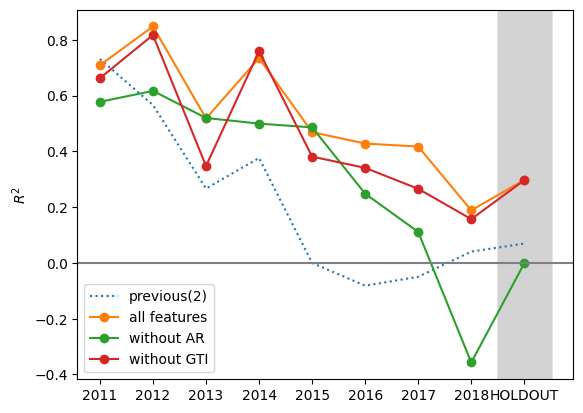

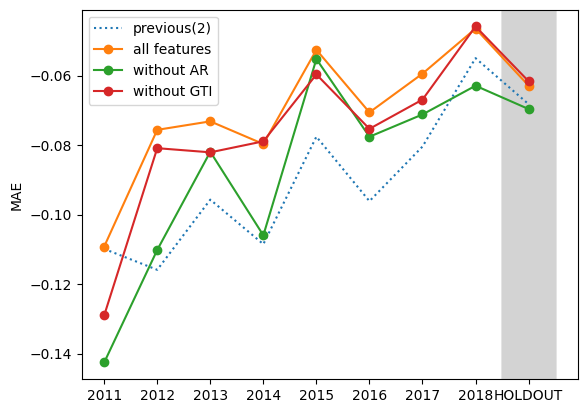

In [6]:
comp_models = [
    "bench_previous_2",
    "linear_all",
    "linear_without_ar",
    "linear_without_google",
]

labels = ["previous(2)", "all features", "without AR", "without GTI"]

indices = [model_names.index(name) for name in comp_models]
benchmark_indices = [0, 1]
metrics = ["r2_mod", "mae"]
y_labels = ["$R^2$", "MAE"]

fold_labels = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, "HOLDOUT"]

for m, ylabel in zip(metrics, y_labels):
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=model_names,
        plot_labels=labels,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=fold_labels.index("HOLDOUT"),
        benchmark_indices=benchmark_indices,
        y_label=ylabel
    )
    if m == "r2_mod":
        plt.axhline(0.0, c="grey")
    plt.show()


#### Performance by year ensemble vs linear

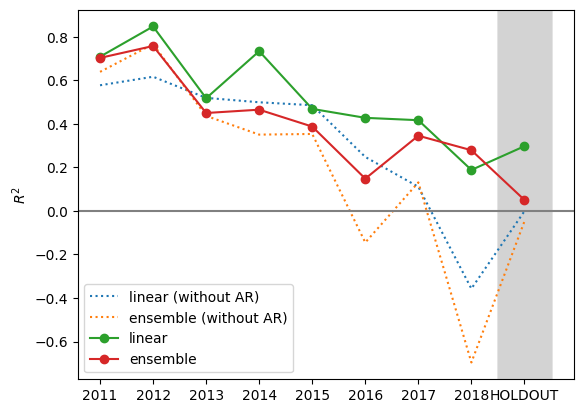

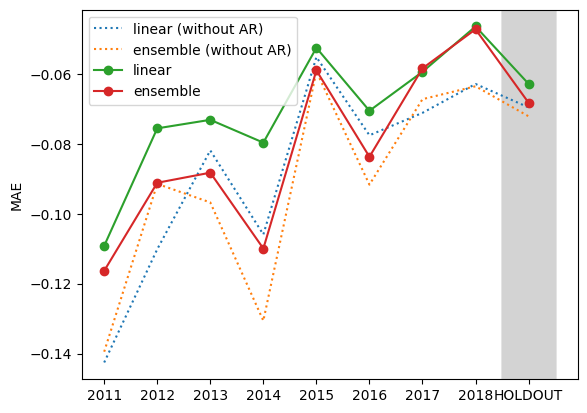

In [7]:
comp_models = [
    "linear_without_ar",
    "ensemble_without_ar",
    "linear_all",
    "ensemble_all",    
]

labels = ["linear (without AR)", "ensemble (without AR)", "linear", "ensemble"]

indices = [model_names.index(name) for name in comp_models]
benchmark_indices = [2, 5]
metrics = ["r2_mod", "mae"]
y_labels = ["$R^2$", "MAE"]

fold_labels = [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, "HOLDOUT"]

for m, ylabel in zip(metrics, y_labels):
    eumf_eval.cv_performance_plot(
        cv_scores,
        m,
        indices=indices,
        run_labels=model_names,
        plot_labels=labels,
        fold_labels=fold_labels,
        test_scores=test_scores,
        test_pos=fold_labels.index("HOLDOUT"),
        benchmark_indices=benchmark_indices,
        y_label=ylabel
    )
    if m == "r2_mod":
        plt.axhline(0.0, c="grey")
    plt.show()


### Point analyses Trends vs no Trends

In [11]:
i_1 = model_names.index("linear_without_google")
i_2 = model_names.index("linear_all")

arr_pred_1 = model_selection.cross_val_predict(
    estimators[i_1], train_stackeds[i_1].x, train_stackeds[i_1].y, cv=cv_default
)
arr_pred_2 = model_selection.cross_val_predict(
    estimators[i_2], train_stackeds[i_2].x, train_stackeds[i_2].y, cv=cv_default
)

df_pred = train_stackeds[i_1].y.to_frame(name="true").reset_index()
df_pred["year"] = df_pred["date"].dt.year.astype(str)
df_pred["pred_value"] = arr_pred_1
df_pred["pred_trends"] = arr_pred_2
df_pred["err_value"] = np.abs(df_pred["true"] - df_pred["pred_value"])
df_pred["err_trends"] = np.abs(df_pred["true"] - df_pred["pred_trends"])
df_pred["delta"] = df_pred["err_value"] - df_pred["err_trends"]

df_pred.head()


,date,level_1,true,year,pred_value,pred_trends,err_value,err_trends,delta
0,2011-03-31,AT+CH,0.053,2011,0.050,0.100,2.936e-03,0.047,-0.044
1,2011-03-31,BE+NL+LU,0.099,2011,0.046,0.065,5.368e-02,0.034,0.019
2,2011-03-31,BG,0.343,2011,0.299,0.354,4.378e-02,0.011,0.032
3,2011-03-31,CZ+SK,0.126,2011,0.127,0.159,4.998e-04,0.033,-0.032
4,2011-03-31,ES,0.355,2011,0.176,0.332,1.797e-01,0.023,0.156


In [12]:
df_pred[["true", "delta"]].corr()

,true,delta
true,1.000,0.143
delta,0.143,1.000


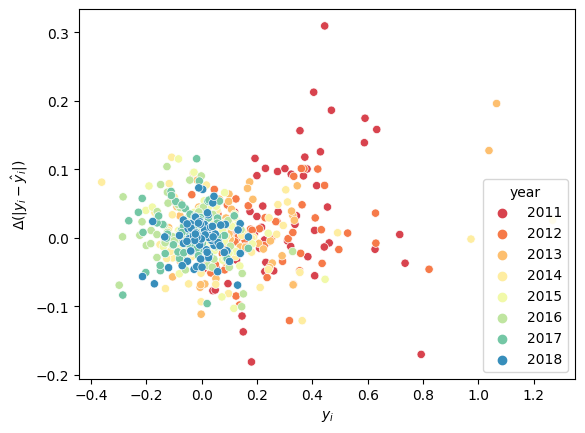

In [14]:
sns.scatterplot(data=df_pred, x="true", y="delta", hue="year", palette="Spectral")
plt.xlabel(r"$y_i$")
plt.ylabel(r"$\Delta(|y_i-\^y_i|)$")
plt.show()

### Performance by country

##### prepare dummy scores (const 0)

In [11]:
#test_scores_c_dummy = eumf_eval.score_test_countries(estimators[1], test_stackeds[1])
cv_scores_c_dummy = eumf_eval.score_cv_countries(estimators[0], train_unstackeds[0], cv_default)
cv_scores_c_dummy["rmse"] = -cv_scores_c_dummy["rmse"]
cv_scores_c_dummy["mae"] = -cv_scores_c_dummy["mae"]

##### best model without AR lags: GTI+GDP+Unempl

test scores

In [12]:
i = model_names.index("linear_without_ar")


In [13]:
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse"] = -test_scores_c["rmse"]
test_scores_c["mae"] = -test_scores_c["mae"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
IT,0.033,0.041,0.288,0.511,0.024
IE,0.023,0.035,-0.530,0.438,0.017
HU,0.138,0.144,-0.829,0.419,0.048
ES,0.028,0.031,0.386,0.351,0.005
RO,0.071,0.081,0.143,0.265,0.009
PL,0.105,0.119,-0.361,0.164,0.008
SE+FI+DK,0.044,0.058,0.143,0.156,0.003
LV+LT+EE,0.043,0.056,-1.423,0.083,0.003
FR,0.013,0.015,0.076,0.074,0.002
HR,0.195,0.202,0.436,0.066,0.002


CV scores

In [14]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
plot_order = cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False).index.to_list()

display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))



CV scores per country:


mae                  rmse                explained_variance                 r2_mod               delta_mae              
          mean   std    sem    mean   std    sem          mean          std     sem    mean   std    sem      mean    std    sem  
ES        0.076  0.059  0.021  0.084  0.065  0.023        0.125         1.127   0.398  0.606  0.461  0.163    0.119   0.124  0.044
PT        0.085  0.045  0.016  0.099  0.050  0.018       -0.021         0.296   0.105  0.532  0.391  0.138    0.085   0.101  0.036
RO        0.086  0.064  0.023  0.097  0.066  0.023       -0.840         1.456   0.515  0.379  0.523  0.185    0.070   0.073  0.026
HU        0.094  0.079  0.028  0.110  0.088  0.031       -0.750         1.120   0.396  0.311  0.578  0.205    0.042   0.037  0.013
SI        0.198  0.162  0.057  0.233  0.190  0.067       -0.559         1.166   0.412  0.248  0.291  0.103    0.048   0.064  0.023
BE+NL+LU  0.042  0.015  0.005  0.048  0.016  0.006       -0.638         0.728   0.257  0.136  0.414  0.146    0.008   0.019  0.007
IT        0.078  0.051  0.018  0.085  0.050  0.018       -0.040         0.835   0.295  0.039  1.519  0.537    0.085   0.103  0.036
HR        0.174  0.156  0.055  0.218  0.199  0.070       -1.377         2.716   0.960  0.018  1.214  0.429    0.074   0.120  0.042
CZ+SK     0.082  0.044  0.015  0.102  0.056  0.020       -0.153         0.928   0.328  0.011  0.950  0.336    0.031   0.057  0.020
GB        0.051  0.031  0.011  0.057  0.030  0.011       -0.325         0.905   0.320 -0.069  0.634  0.224    0.003   0.024  0.009
FR        0.038  0.018  0.006  0.045  0.019  0.007      -24.294        68.830  24.335 -0.092  0.851  0.301    0.007   0.018  0.006
BG        0.083  0.097  0.034  0.088  0.097  0.034       -0.170         1.362   0.481 -0.596  2.409  0.852    0.028   0.074  0.026
PL        0.070  0.039  0.014  0.079  0.044  0.016        0.191         0.470   0.166 -0.707  3.556  1.257    0.037   0.092  0.033
LV+LT+EE  0.092  0.054  0.019  0.102  0.056  0.020       -0.366         0.719   0.254 -0.783  2.405  0.850    0.024   0.073  0.026
AT+CH     0.049  0.031  0.011  0.064  0.046  0.016       -1.540         4.017   1.420 -0.801  2.278  0.805    0.006   0.023  0.008
IE        0.109  0.041  0.014  0.127  0.043  0.015       -1.007         1.903   0.673 -0.815  0.978  0.346   -0.008   0.046  0.016
SE+FI+DK  0.040  0.009  0.003  0.047  0.008  0.003       -1.474         3.685   1.303 -2.133  4.949  1.750    0.003   0.038  0.013
GR        0.147  0.062  0.022  0.165  0.064  0.023       -1.029         1.458   0.515 -4.831  9.074  3.208    0.027   0.163  0.058

plot MAE absolute

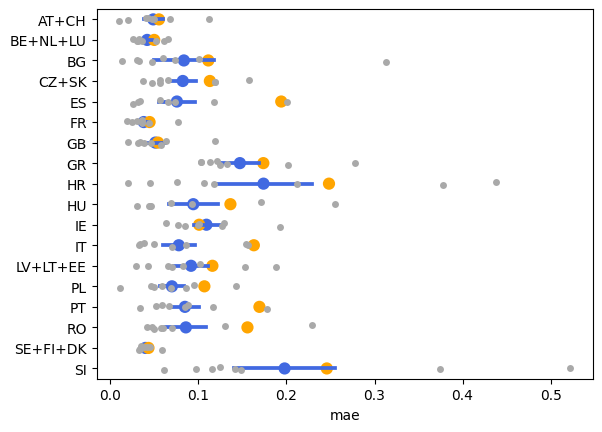

In [15]:
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae", color="darkgrey")
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="royalblue",
    errorbar=("se", 1)
)
sns.pointplot(
    data=cv_scores_c_dummy.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="orange",
    errorbar=None,
    markers="o",
)
# sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()


 plot r^2

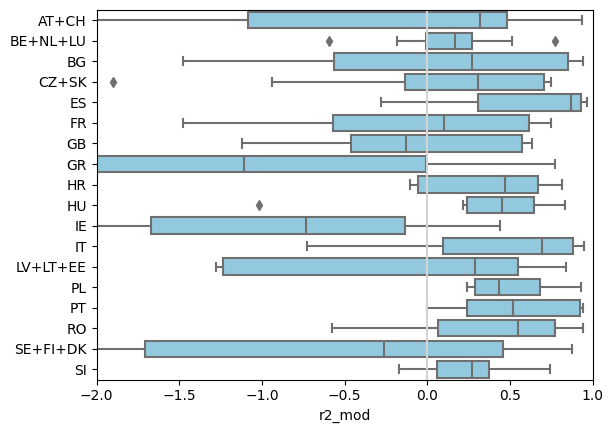

In [16]:
# sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="r2_mod", color="darkgrey")
sns.boxplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="r2_mod",
    # linestyles="",
    color="skyblue",
    # estimator="median",
    # errorbar=("se", 1)
)
# sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.xlim(-2,1.0)
plt.axvline(0.0, c="lightgrey")
plt.show()


##### best model with AR lags: value + KW19

test scores

In [17]:
i = model_names.index("linear_without_ar")

In [18]:
test_scores_c = eumf_eval.score_test_countries(estimators[i], test_stackeds[i])
test_scores_c["rmse"] = -test_scores_c["rmse"]
test_scores_c["mae"] = -test_scores_c["mae"]
print("Holdout scores per country:")
display(test_scores_c.sort_values(by="r2_mod", ascending=False))

Holdout scores per country:


,mae,rmse,explained_variance,r2_mod,delta_mae
IT,0.031,0.043,0.259,0.472,0.026
IE,0.022,0.034,-0.162,0.455,0.017
HU,0.139,0.145,-0.752,0.414,0.047
ES,0.029,0.032,0.259,0.308,0.004
RO,0.073,0.082,0.125,0.246,0.007
PL,0.103,0.116,-0.323,0.213,0.011
SE+FI+DK,0.044,0.058,0.142,0.153,0.004
HR,0.196,0.203,0.426,0.058,0.001
GB,0.079,0.127,0.066,0.016,0.009
LV+LT+EE,0.047,0.059,-1.742,-0.041,-0.001


CV scores

In [19]:
cv_scores_c = eumf_eval.score_cv_countries(estimators[i], train_unstackeds[i], cv_default)
cv_scores_c["rmse"] = -cv_scores_c["rmse"]
cv_scores_c["mae"] = -cv_scores_c["mae"]

print("CV scores per country:")
cv_scores_c_agg = eumf_eval.agg_cv_scores(cv_scores_c, level=0, use_quantiles=False)
display(cv_scores_c_agg.sort_values(by=("r2_mod", "mean"), ascending=False))


CV scores per country:


mae                  rmse                explained_variance                 r2_mod               delta_mae              
          mean   std    sem    mean   std    sem          mean          std     sem    mean   std    sem      mean    std    sem  
ES        0.076  0.059  0.021  0.084  0.065  0.023        0.125         1.127   0.398  0.606  0.461  0.163    0.119   0.124  0.044
PT        0.085  0.045  0.016  0.099  0.050  0.018       -0.021         0.296   0.105  0.532  0.391  0.138    0.085   0.101  0.036
RO        0.086  0.064  0.023  0.097  0.066  0.023       -0.840         1.456   0.515  0.379  0.523  0.185    0.070   0.073  0.026
HU        0.094  0.079  0.028  0.110  0.088  0.031       -0.750         1.120   0.396  0.311  0.578  0.205    0.042   0.037  0.013
SI        0.198  0.162  0.057  0.233  0.190  0.067       -0.559         1.166   0.412  0.248  0.291  0.103    0.048   0.064  0.023
BE+NL+LU  0.042  0.015  0.005  0.048  0.016  0.006       -0.638         0.728   0.257  0.136  0.414  0.146    0.008   0.019  0.007
IT        0.078  0.051  0.018  0.085  0.050  0.018       -0.040         0.835   0.295  0.039  1.519  0.537    0.085   0.103  0.036
HR        0.174  0.156  0.055  0.218  0.199  0.070       -1.377         2.716   0.960  0.018  1.214  0.429    0.074   0.120  0.042
CZ+SK     0.082  0.044  0.015  0.102  0.056  0.020       -0.153         0.928   0.328  0.011  0.950  0.336    0.031   0.057  0.020
GB        0.051  0.031  0.011  0.057  0.030  0.011       -0.325         0.905   0.320 -0.069  0.634  0.224    0.003   0.024  0.009
FR        0.038  0.018  0.006  0.045  0.019  0.007      -24.294        68.830  24.335 -0.092  0.851  0.301    0.007   0.018  0.006
BG        0.083  0.097  0.034  0.088  0.097  0.034       -0.170         1.362   0.481 -0.596  2.409  0.852    0.028   0.074  0.026
PL        0.070  0.039  0.014  0.079  0.044  0.016        0.191         0.470   0.166 -0.707  3.556  1.257    0.037   0.092  0.033
LV+LT+EE  0.092  0.054  0.019  0.102  0.056  0.020       -0.366         0.719   0.254 -0.783  2.405  0.850    0.024   0.073  0.026
AT+CH     0.049  0.031  0.011  0.064  0.046  0.016       -1.540         4.017   1.420 -0.801  2.278  0.805    0.006   0.023  0.008
IE        0.109  0.041  0.014  0.127  0.043  0.015       -1.007         1.903   0.673 -0.815  0.978  0.346   -0.008   0.046  0.016
SE+FI+DK  0.040  0.009  0.003  0.047  0.008  0.003       -1.474         3.685   1.303 -2.133  4.949  1.750    0.003   0.038  0.013
GR        0.147  0.062  0.022  0.165  0.064  0.023       -1.029         1.458   0.515 -4.831  9.074  3.208    0.027   0.163  0.058

plot MAE absolute

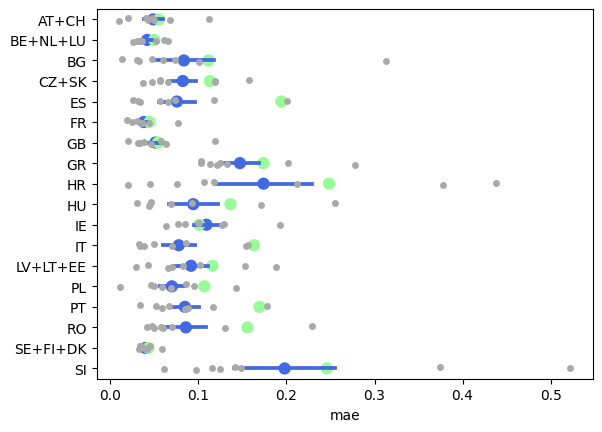

In [20]:
sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="mae", color="darkgrey")
sns.pointplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="royalblue",
    errorbar=("se", 1)
)
sns.pointplot(
    data=cv_scores_c_dummy.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="palegreen",
    errorbar=None,
    markers="o",
)
# sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.show()

 plot r^2

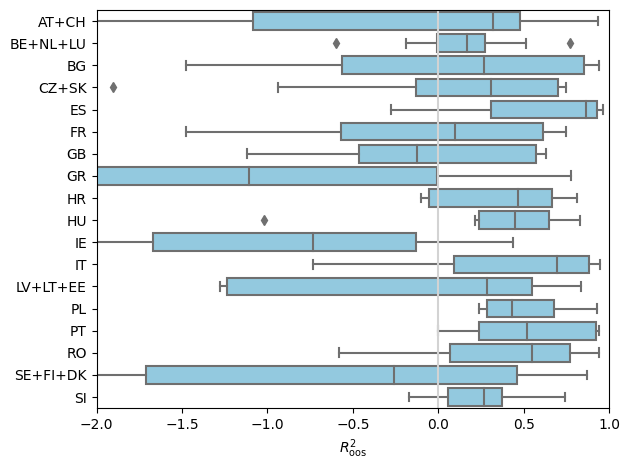

In [21]:
# sns.stripplot(data=cv_scores_c.reset_index(), y="level_0", x="r2_mod", color="darkgrey")
sns.boxplot(
    data=cv_scores_c.reset_index(),
    y="level_0",
    x="r2_mod",
    # linestyles="",
    color="skyblue",
    # estimator="median",
    # errorbar=("se", 1)
)
# sns.stripplot(data=test_scores_c.reset_index(), y="index", x="mae", color="k")
plt.ylabel("")
plt.xlim(-2,1.0)
plt.axvline(0.0, c="lightgrey")
plt.xlabel("$R^2_{\operatorname{oos}}$")
plt.tight_layout()
plt.savefig("plots/best_model_r2_countries.pdf")
plt.show()


#### How important is Google Trends for each country? (diff trends vs no trends)


In [22]:
i1 = model_names.index("linear_all")
i2 = model_names.index("linear_without_google")

reg1, reg2 = tuners[i1].best_estimator_, tuners[i2].best_estimator_

cv_scores_c1 = eumf_eval.score_cv_countries(reg1, train_unstackeds[i1], cv_default)
cv_scores_c_agg1 = eumf_eval.agg_cv_scores(cv_scores_c1, level=0)
cv_scores_c2 = eumf_eval.score_cv_countries(reg2, train_unstackeds[i2], cv_default)
cv_scores_c_agg2 = eumf_eval.agg_cv_scores(cv_scores_c2, level=0)

cv_diff = cv_scores_c1 - cv_scores_c2
cv_diff_agg = eumf_eval.agg_cv_scores(cv_diff, level=0,)

cv_diff_agg["rmse"]

,mean,std,sem
AT+CH,4.769e-03,0.026,0.009
BE+NL+LU,3.772e-03,0.008,0.003
BG,-8.666e-03,0.029,0.010
CZ+SK,1.346e-02,0.021,0.007
ES,4.530e-02,0.058,0.020
FR,-8.971e-03,0.017,0.006
GB,4.175e-03,0.012,0.004
GR,1.443e-02,0.043,0.015
HR,-1.563e-02,0.061,0.022
HU,6.419e-04,0.012,0.004


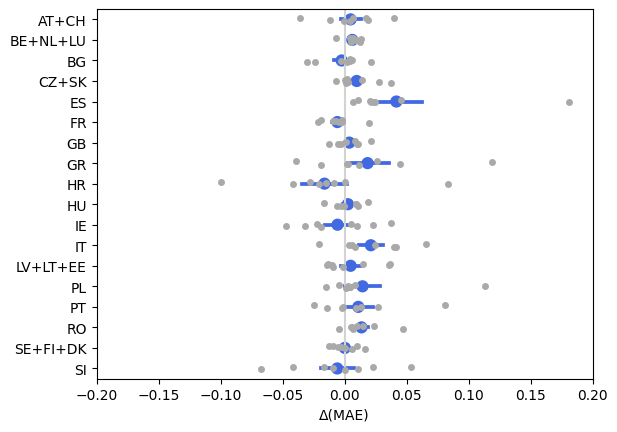

In [23]:
sns.stripplot(data=cv_diff.reset_index(), y="level_0", x="mae", color="darkgrey")
sns.pointplot(
    data=cv_diff.reset_index(),
    y="level_0",
    x="mae",
    linestyles="",
    color="royalblue",
    estimator="mean",
    errorbar=("se", 1)
)
plt.axvline(0.0, c="lightgrey")
plt.ylabel("")
plt.xlabel("Δ(MAE)")
plt.xlim(-0.20,0.20)
plt.show()


#### Plot prediction

all features

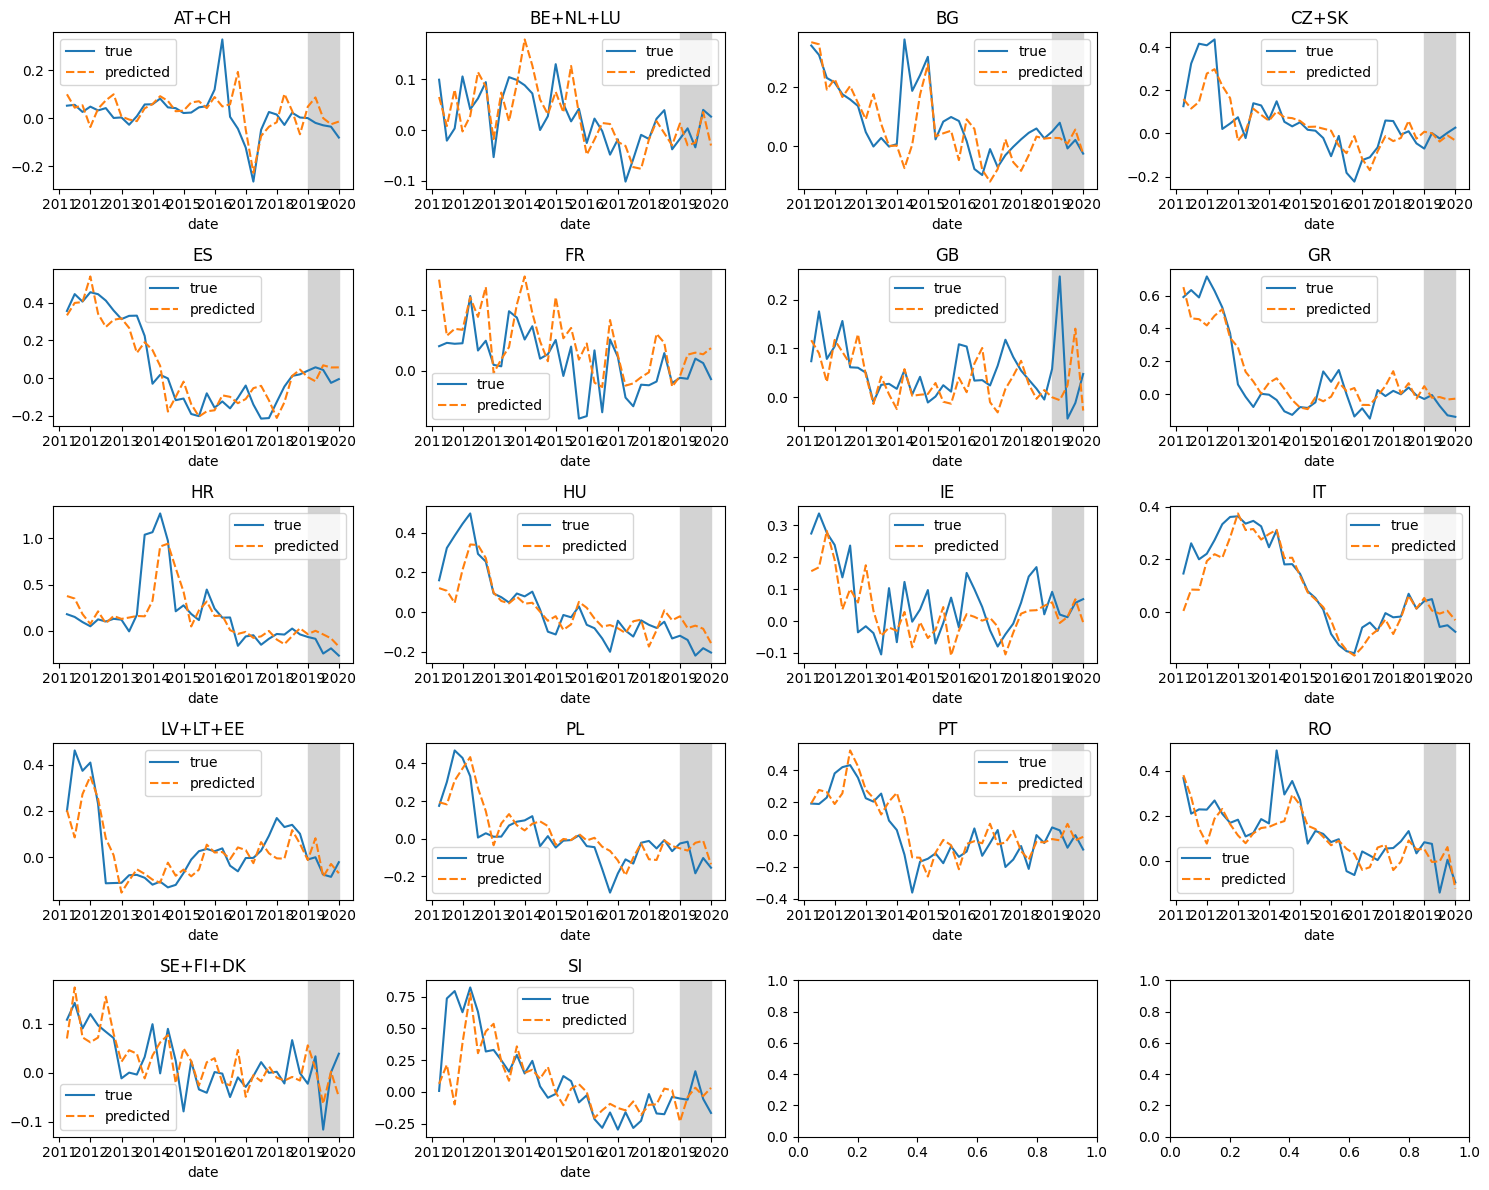

In [24]:
i = model_names.index("linear_all")
reg = tuners[i].best_estimator_

y_pred_all = eumf_eval.predict_all(reg, train_stackeds[i], test_stackeds[i], cv_default)

fig, axs = eumf_eval.plot_prediction(
    y_pred_all,
    transformed.y,
    # eumf_pipeline.inv_transform_y(y_pred_all, labeled.y),
    # labeled.y,
    n_rows=5,
    n_cols=4,
    figsize=(15, 12),
    y_min=-0.5,
    y_max=1.5,
    marker="",
    t_min="2011",
    vspan=("2019", "2020"),
    t_max="2019",
)
plt.show()
